# 🚢 Titanic Survival Prediction

**Author:** Milos Saric [https://saricmilos.com/]
**Date:** October 7, 2025  
**Dataset:** Titanic Passenger Data  

---

This notebook explores the classic Titanic dataset to predict passenger survival using machine learning.  
The analysis will guide you through the full data science workflow, including:

1. **Exploratory Data Analysis (EDA):** Understanding the dataset, visualizing trends, and identifying patterns.  
2. **Feature Engineering:** Creating and transforming features to improve model performance.  
3. **Modeling & Evaluation:** Training multiple machine learning models, comparing their performance, and selecting the best predictor for survival.  

The goal of this project is to apply practical data science techniques to a real-world dataset and gain insights into the factors that influenced survival on the Titanic.


## 1) Import Required Libraries  

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Any
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

## 2) Define Functions Required

In [2]:
# Load our datasets
def load_dataset(csv_path: Path, **read_csv_kwargs: Any) -> pd.DataFrame:
    """     
    Load a CSV file into a pandas DataFrame.
    
    Args:
        csv_path (Path): Full path to the CSV file
        **read_csv_kwargs: Optional arguments for pd.read_csv

    Returns:
        pd.DataFrame
     """
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    return pd.read_csv(csv_path, **read_csv_kwargs)

In [3]:
# Function to extract title from the name
def extract_title(name):
    match = re.search(r", (\w+)\.",name)
    return match.group(1) if match else ""

In [4]:
# Function to determine size of the family from number of family members (cousins, children, parents):
def family_category(size):
    if size == 1:
        return "Single"
    elif size <= 4:
        return "SmallFamily"
    else:
        return "LargeFamily"

In [5]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name=None, labels=None, figsize=(6, 4), normalize=False):
    """
    Plot a confusion matrix using Seaborn.
    
    Parameters:
        y_true : array-like, true labels
        y_pred : array-like, predicted labels
        model_name : str, optional, name of the model for the title
        labels : list, optional, class labels
        figsize : tuple, optional, size of the figure
        normalize : bool, optional, normalize counts to percentages
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap="Blues", cbar=False,
                xticklabels=labels if labels is not None else True,
                yticklabels=labels if labels is not None else True)
    
    title = "Confusion Matrix"
    if model_name:
        title += f" - {model_name}"
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [6]:
# Function to plot most important features
def plot_feature_importance(model, feature_names, top_n=15):
    # Some models (like XGBoost/RandomForest) have 'feature_importances_'
    importance = model.feature_importances_
    fi = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(8, 6))
    plt.barh(fi['Feature'], fi['Importance'])
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Feature Importances for {type(model).__name__}")
    plt.xlabel("Importance Score")
    plt.show()

## 3) Load Datasets

In [7]:
dataset_folder = Path(r"C:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\1. Titanic Survival Predictor\Data")
datasets = {}

In [8]:
for csv_file in dataset_folder.glob("*.csv"):
    datasets[csv_file.stem] = load_dataset(csv_file)

In [9]:
print(f"{datasets.keys()}")

dict_keys(['gender_submission', 'test', 'train'])


In [10]:
datasets["train"].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 4) Exploratory Data Analysis

In [11]:
datasets["train"].shape

(891, 12)

In [12]:
datasets["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
datasets["train"].isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [14]:
label_counts = datasets['train']["Survived"].value_counts()
print(label_counts)


label_percentages = datasets['train']["Survived"].value_counts(normalize=True) * 100
print(label_percentages)

Survived
0    549
1    342
Name: count, dtype: int64
Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64


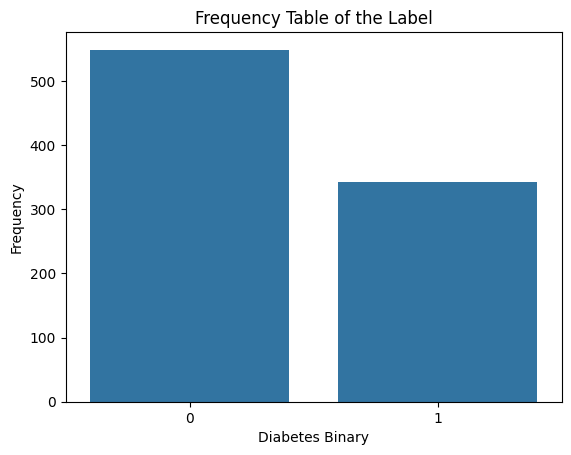

Total number of labels:  891


In [15]:
x = datasets["train"]["Survived"].value_counts().values 
labels = datasets["train"]["Survived"].value_counts().index 

# Use the correct syntax for barplot
sns.barplot(x=labels, y=x)
plt.title('Frequency Table of the Label')
plt.xlabel('Diabetes Binary')
plt.ylabel('Frequency')
plt.show()

# Print the total number of labels
print('Total number of labels: ', sum(x))

### Correlation matrix

In [16]:
corr = datasets["train"].select_dtypes(include=["number"]).corr(method="spearman")
corr1 = corr.abs()

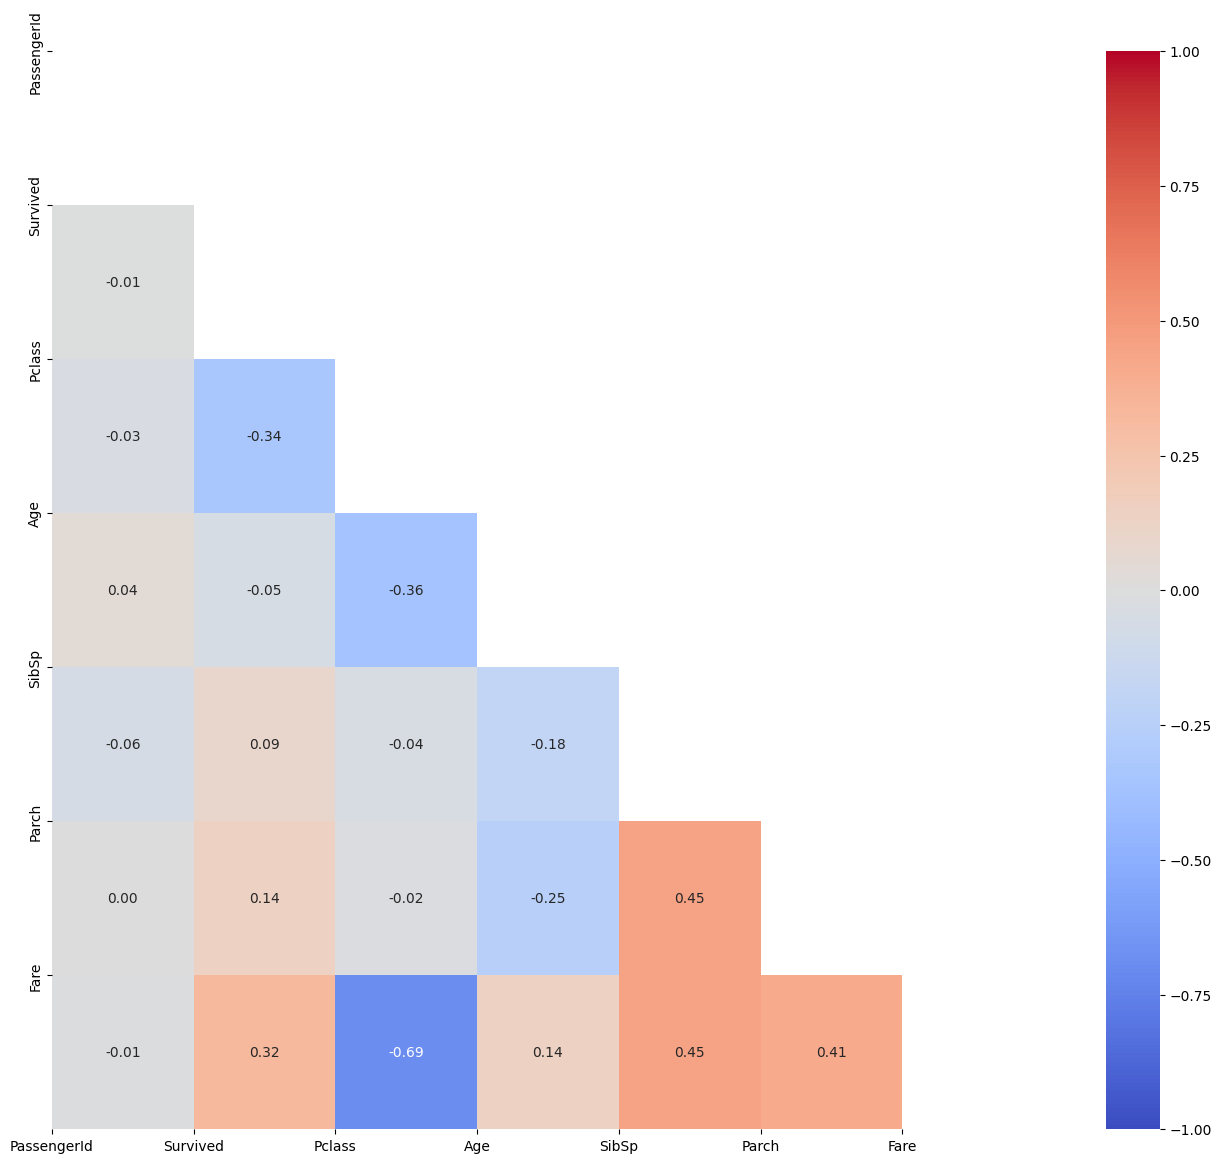

In [17]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
  
f, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", vmin=-1, vmax=1)
    # xticks
plt.xticks(range(len(corr.columns)), corr.columns);
    # yticks
plt.yticks(range(len(corr.columns)), corr.columns)
    # plot
plt.show()

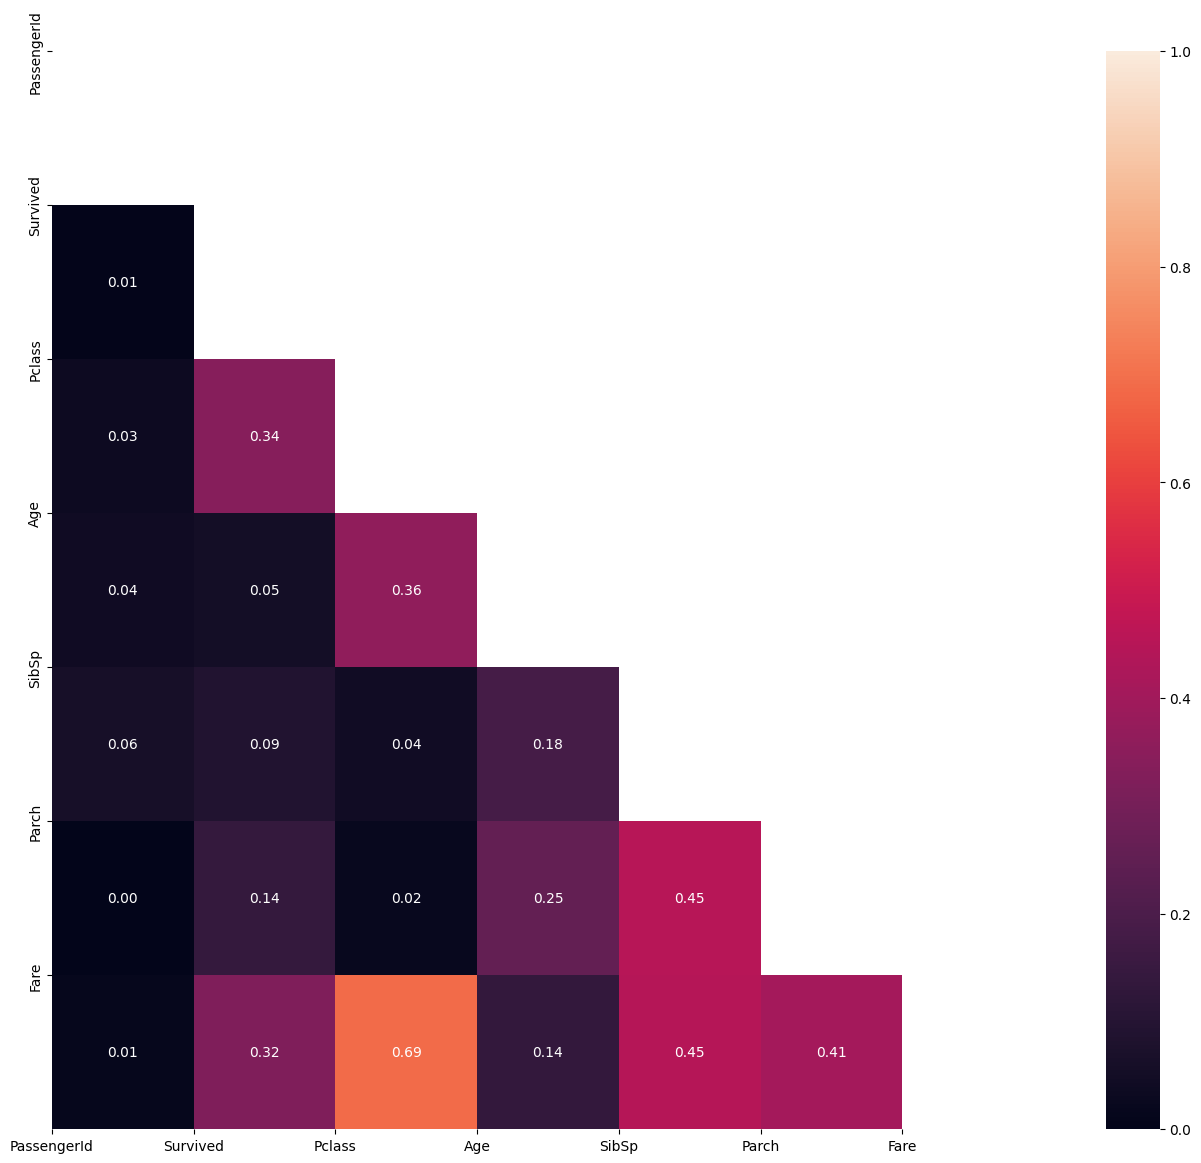

In [18]:
mask = np.zeros_like(corr1, dtype=bool)
mask[np.triu_indices_from(mask)] = True
  
f, ax = plt.subplots(figsize=(16, 14))

sns.heatmap(corr1, annot=True, fmt=".2f", mask=mask, vmin=0, vmax=1)
    # xticks
plt.xticks(range(len(corr1.columns)), corr1.columns);
    # yticks
plt.yticks(range(len(corr1.columns)), corr1.columns)
    # plot
plt.show()

In [19]:
datasets["train"]["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [20]:
datasets["train"].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


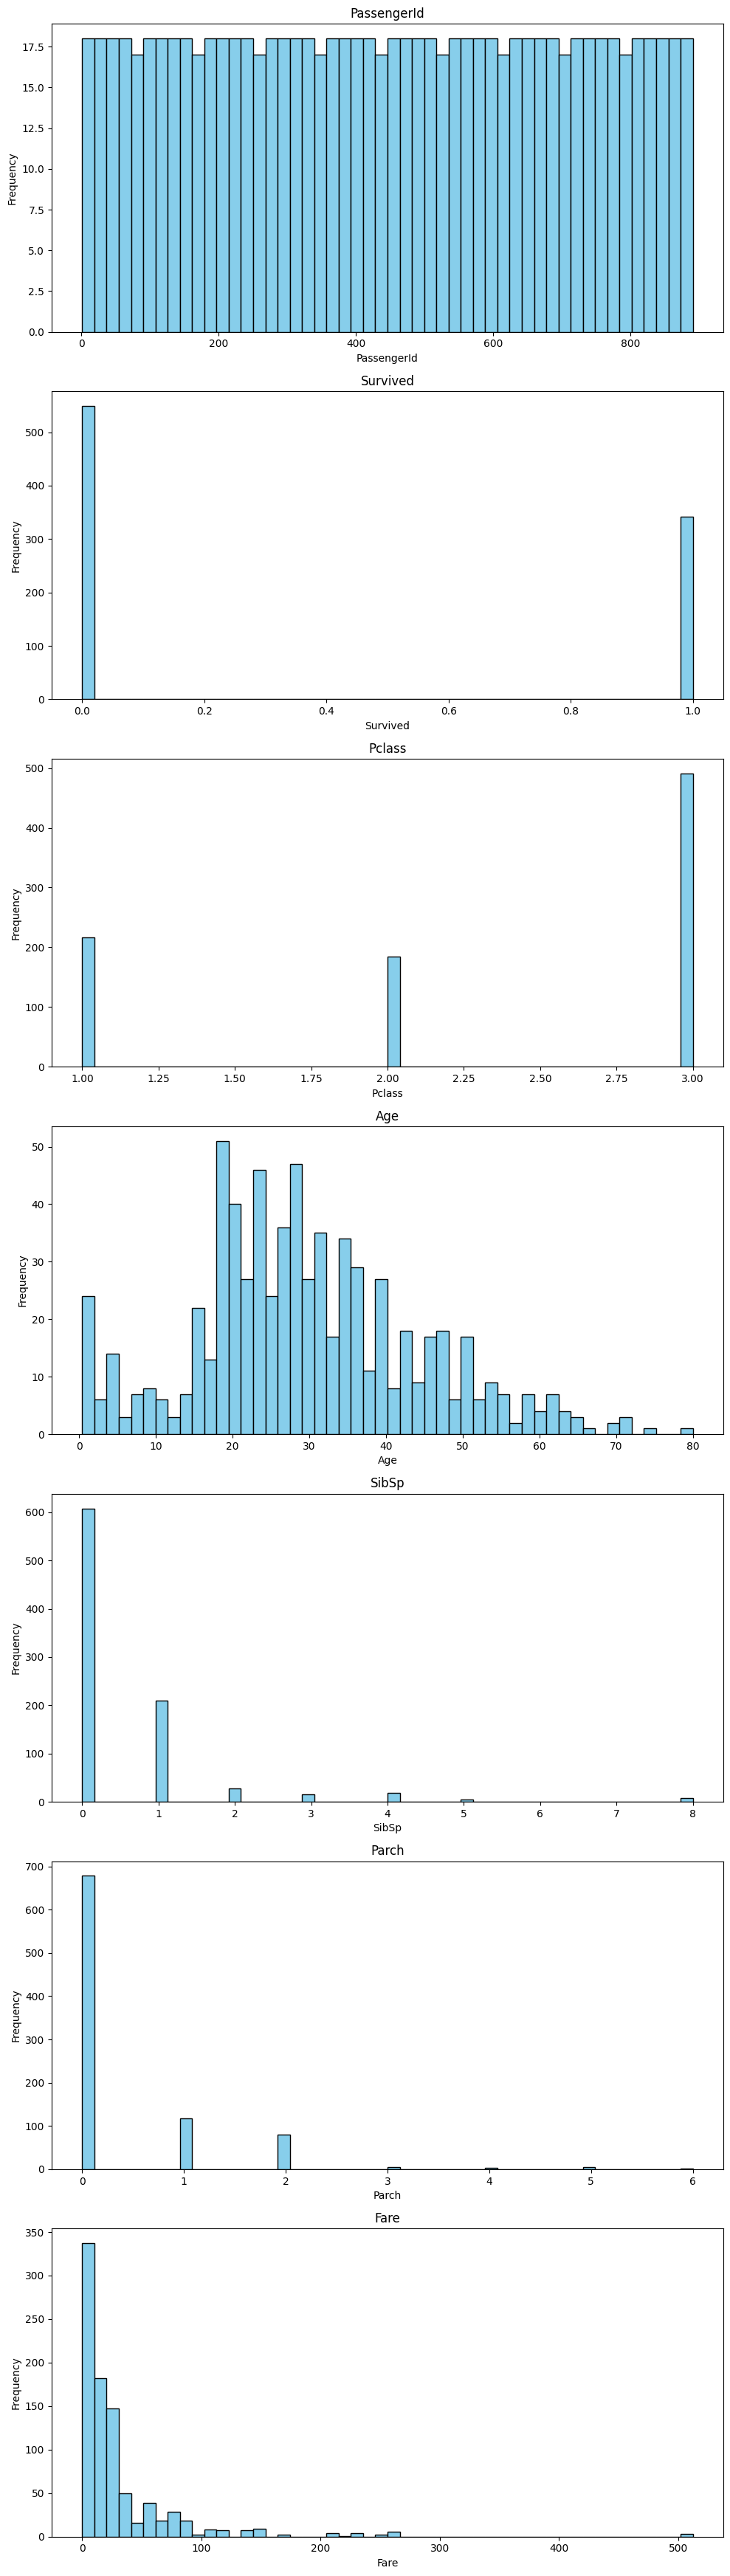

In [21]:
numeric_cols = datasets["train"].select_dtypes(include='number').columns
fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=1, figsize=(10, 5*len(numeric_cols)))

for ax, col in zip(axes, numeric_cols):
    ax.hist(datasets["train"][col], bins=50, color='skyblue', edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## 5) Feature Engineering

### 5.1) Title of each passenger

In [22]:
rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Mlle', 'Countess', 'Ms', 'Lady', 'Jonkheer', 'Don', 'Capt', 'Sir']
title_mapping = {"Mr":0,"Miss":1,"Mrs":2,"Master":3,"Rare":4,"Unknown":5}
for df in [datasets["train"], datasets["test"]]:
    df['Title'] = df['Name'].apply(extract_title)
    df["Title"] = df["Title"].replace(rare_titles,"Rare")
    df["Title"].fillna("Unknown", inplace=True)
    df["Title"] = df["Title"].map(title_mapping)

C:\Users\Milos\AppData\Local\Temp\ipykernel_20636\1287186023.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Title"].fillna("Unknown", inplace=True)
C:\Users\Milos\AppData\Local\Temp\ipykernel_20636\1287186023.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

In [23]:
datasets["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Title        889 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 90.6+ KB


### 5.2) Family Size

In [24]:
family_mapping = {'Single': 0, 'SmallFamily': 1, 'LargeFamily': 2}

In [25]:
for df in [datasets["train"],datasets["test"]]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["FamilyCategory"] = df["FamilySize"].apply(family_category).map(family_mapping)
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

In [26]:
datasets["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Name            891 non-null    object 
 4   Sex             891 non-null    object 
 5   Age             714 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Cabin           204 non-null    object 
 11  Embarked        889 non-null    object 
 12  Title           889 non-null    float64
 13  FamilySize      891 non-null    int64  
 14  FamilyCategory  891 non-null    int64  
 15  IsAlone         891 non-null    int64  
dtypes: float64(3), int64(8), object(5)
memory usage: 111.5+ KB


### 5.3) Age Category

In [27]:
bins = [0,12,18,35,60,120]
labels = ["Child","Teen","Adult","MiddleAge","Senior"]
age_mapping = {"Child": 0,"Teen": 1,"Adult": 2,"MiddleAge": 3,"Senior": 4}
for df in [datasets["train"],datasets["test"]]:
    # Flag missing ages
    df["AgeMissing"] = df['Age'].isna().astype(int)
    # Fill missing ages with median per Title
    df["Age"] = df.groupby("Title")["Age"].transform(lambda x: x.fillna(x.median()))
    df["AgeGroup"] = pd.cut(df["Age"],bins=bins,labels=labels).map(age_mapping)

In [28]:
datasets["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     891 non-null    int64   
 1   Survived        891 non-null    int64   
 2   Pclass          891 non-null    int64   
 3   Name            891 non-null    object  
 4   Sex             891 non-null    object  
 5   Age             889 non-null    float64 
 6   SibSp           891 non-null    int64   
 7   Parch           891 non-null    int64   
 8   Ticket          891 non-null    object  
 9   Fare            891 non-null    float64 
 10  Cabin           204 non-null    object  
 11  Embarked        889 non-null    object  
 12  Title           889 non-null    float64 
 13  FamilySize      891 non-null    int64   
 14  FamilyCategory  891 non-null    int64   
 15  IsAlone         891 non-null    int64   
 16  AgeMissing      891 non-null    int64   
 17  AgeGroup        

### 5.4) Fare Prices Category

In [29]:
for df in [datasets["train"],datasets["test"]]:
    df["FareBin"] = pd.qcut(df["Fare"],4,labels = [0,1,2,3])

### 5.5) Sex Mapping

In [30]:
sex_mapping = {"male": 0, "female": 1}
for df in [datasets["train"],datasets["test"]]:
    df["SexLabels"] = df["Sex"].map(sex_mapping)

In [31]:
datasets["train"].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FamilyCategory,IsAlone,AgeMissing,AgeGroup,FareBin,SexLabels
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,2,1,0,0,2,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2.0,2,1,0,0,3,3,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,1,0,1,0,2,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2.0,2,1,0,0,2,3,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,1,0,1,0,2,1,0
5,6,0,3,"Moran, Mr. James",male,30.0,0,0,330877,8.4583,NaN,Q,0.0,1,0,1,1,2,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0.0,1,0,1,0,3,3,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,3.0,5,2,0,0,0,2,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,2.0,3,1,0,0,2,1,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,2.0,2,1,0,0,1,2,1


### 5.6) Embarked One Hot Encoding

In [32]:
for df in [datasets["train"],datasets["test"]]:
    embarked_dummies = pd.get_dummies(df["Embarked"],prefix = "Embarked",dummy_na = True).astype(int)
    df[embarked_dummies.columns] = embarked_dummies

In [33]:
datasets["train"].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FamilyCategory,IsAlone,AgeMissing,AgeGroup,FareBin,SexLabels,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,0,2,0,0,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,3,3,1,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,0,2,1,1,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,2,3,1,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,2,1,0,0,0,1,0
5,6,0,3,"Moran, Mr. James",male,30.0,0,0,330877,8.4583,...,0,1,1,2,1,0,0,1,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,0,1,0,3,3,0,0,0,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,...,2,0,0,0,2,0,0,0,1,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,...,1,0,0,2,1,1,0,0,1,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,...,1,0,0,1,2,1,1,0,0,0


### 5.7) Cabin OneHot Encoding

In [34]:
datasets["train"]["Cabin"].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [35]:
# Define all possible deck columns - THERE IS NOBODY IN TEST SET FROM DECK T SO WE NEED TO ENSURE WE ALL HAVE SAME COLUMNS
all_decks = ['Deck_A','Deck_B','Deck_C','Deck_D','Deck_E','Deck_F','Deck_G','Deck_Missing','Deck_T']

for df in [datasets["train"], datasets["test"]]:
    df["Deck"] = df["Cabin"].apply(lambda x: str(x)[0] if pd.notna(x) else "Missing")
    deck_dummies = pd.get_dummies(df["Deck"], prefix="Deck").astype(int)
    
    # Add missing columns with zeros
    for col in all_decks:
        if col not in deck_dummies:
            deck_dummies[col] = 0
    
    # Ensure the same order
    deck_dummies = deck_dummies[all_decks]
    
    df[all_decks] = deck_dummies

In [36]:
datasets["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     891 non-null    int64   
 1   Survived        891 non-null    int64   
 2   Pclass          891 non-null    int64   
 3   Name            891 non-null    object  
 4   Sex             891 non-null    object  
 5   Age             889 non-null    float64 
 6   SibSp           891 non-null    int64   
 7   Parch           891 non-null    int64   
 8   Ticket          891 non-null    object  
 9   Fare            891 non-null    float64 
 10  Cabin           204 non-null    object  
 11  Embarked        889 non-null    object  
 12  Title           889 non-null    float64 
 13  FamilySize      891 non-null    int64   
 14  FamilyCategory  891 non-null    int64   
 15  IsAlone         891 non-null    int64   
 16  AgeMissing      891 non-null    int64   
 17  AgeGroup        

In [37]:
corr_new = datasets["train"].select_dtypes(include=["number"]).corr(method="spearman")
corr1_new = corr_new.abs()

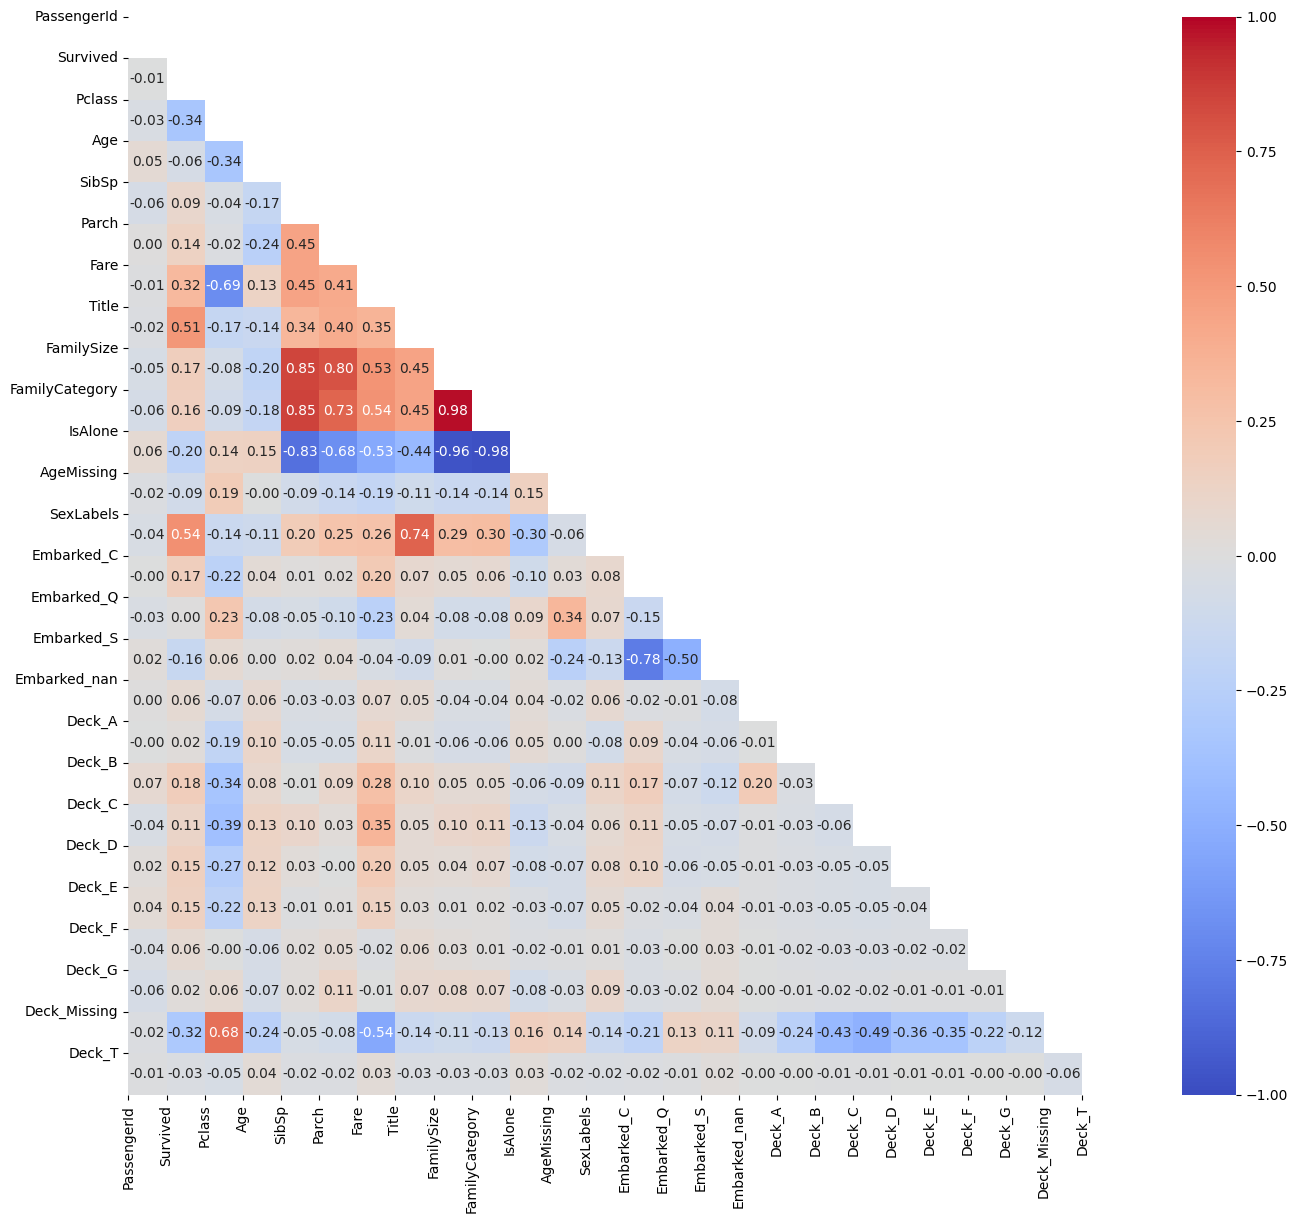

In [38]:
mask = np.zeros_like(corr_new, dtype=bool)
mask[np.triu_indices_from(mask)] = True
  
f, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr_new, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", vmin=-1, vmax=1)
    # xticks
plt.xticks(range(len(corr_new.columns)), corr_new.columns);
    # yticks
plt.yticks(range(len(corr_new.columns)), corr_new.columns)
    # plot
plt.show()

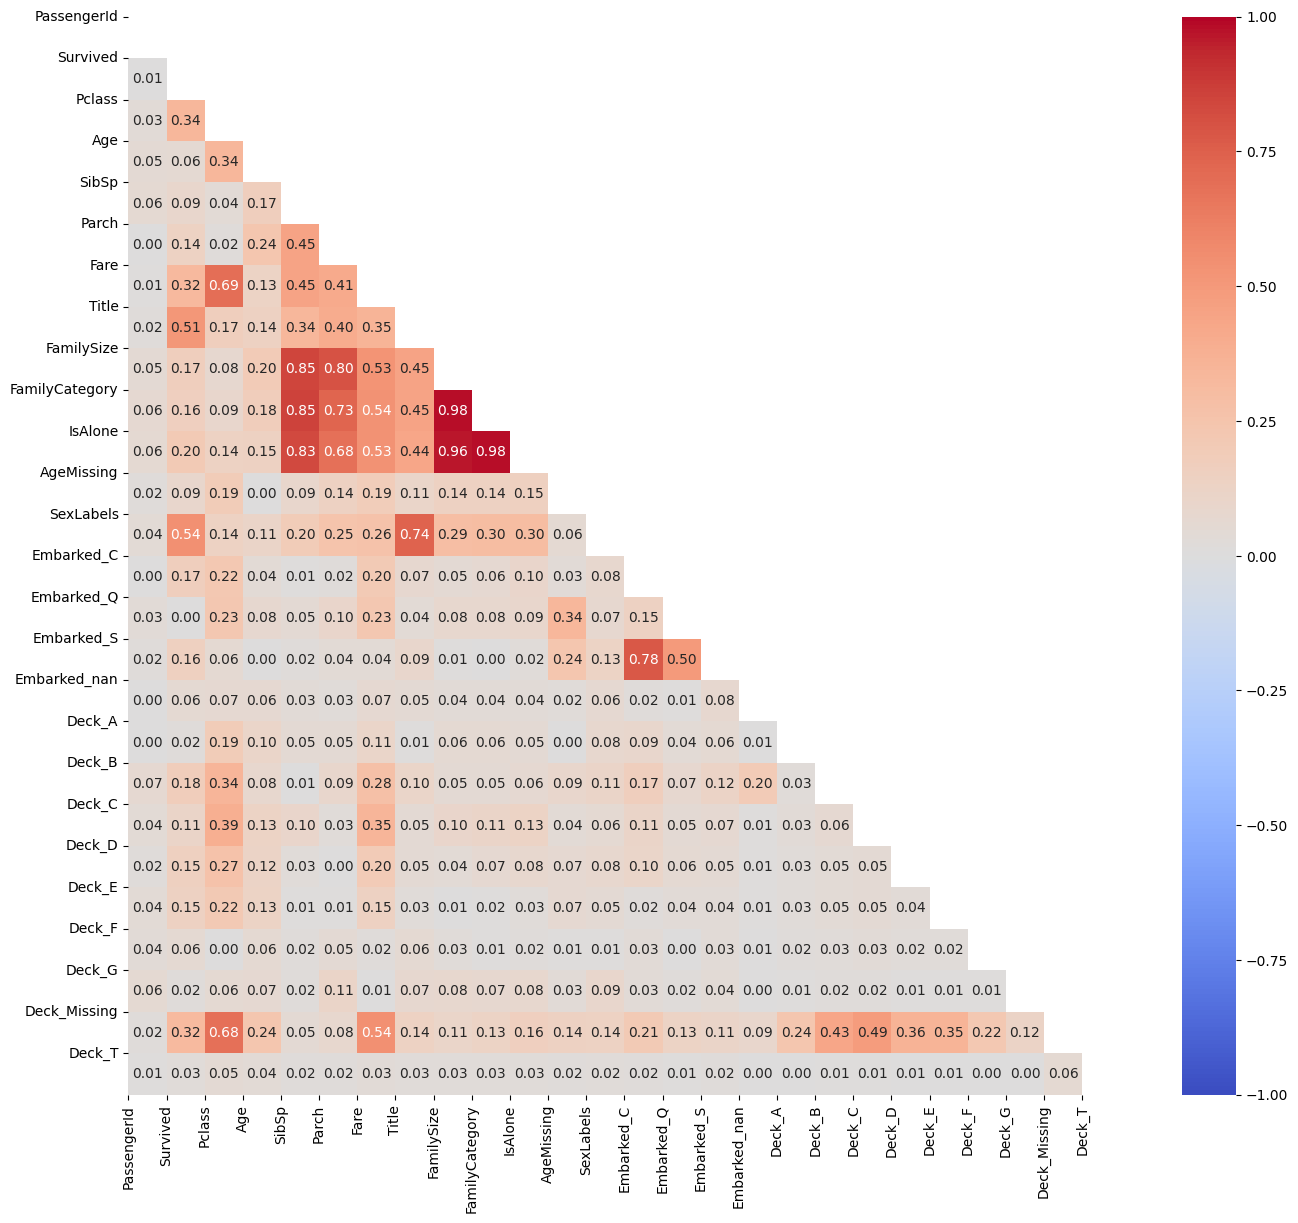

In [39]:
mask = np.zeros_like(corr1_new, dtype=bool)
mask[np.triu_indices_from(mask)] = True
  
f, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr1_new, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", vmin=-1, vmax=1)
    # xticks
plt.xticks(range(len(corr1_new.columns)), corr1_new.columns);
    # yticks
plt.yticks(range(len(corr1_new.columns)), corr1_new.columns)
    # plot
plt.show()

## 6) Model Training & Evaluation

### Removing Unnecessary Original Columns

In [40]:
columns_to_drop = ["PassengerId","Name","Sex","Ticket","Fare","Embarked","Deck","Cabin","Age"]

In [41]:
train_clean = datasets["train"].drop(columns=columns_to_drop, axis = 1)
test_clean = datasets["test"].drop(columns=columns_to_drop, axis = 1)

In [42]:
train_clean.head()

,Survived,Pclass,SibSp,Parch,Title,FamilySize,FamilyCategory,IsAlone,AgeMissing,AgeGroup,...,Embarked_nan,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_Missing,Deck_T
0,0,3,1,0,0.0,2,1,0,0,2,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1,0,2.0,2,1,0,0,3,...,0,0,0,1,0,0,0,0,0,0
2,1,3,0,0,1.0,1,0,1,0,2,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,0,2.0,2,1,0,0,2,...,0,0,0,1,0,0,0,0,0,0
4,0,3,0,0,0.0,1,0,1,0,2,...,0,0,0,0,0,0,0,0,1,0


In [43]:
test_clean.head()

,Pclass,SibSp,Parch,Title,FamilySize,FamilyCategory,IsAlone,AgeMissing,AgeGroup,FareBin,...,Embarked_nan,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_Missing,Deck_T
0,3,0,0,0.0,1,0,1,0,2,0,...,0,0,0,0,0,0,0,0,1,0
1,3,1,0,2.0,2,1,0,0,3,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0.0,1,0,1,0,4,1,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0.0,1,0,1,0,2,1,...,0,0,0,0,0,0,0,0,1,0
4,3,1,1,2.0,3,1,0,0,2,1,...,0,0,0,0,0,0,0,0,1,0


In [44]:
train_clean.isna().sum()

Survived          0
Pclass            0
SibSp             0
Parch             0
Title             2
FamilySize        0
FamilyCategory    0
IsAlone           0
AgeMissing        0
AgeGroup          2
FareBin           0
SexLabels         0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Embarked_nan      0
Deck_A            0
Deck_B            0
Deck_C            0
Deck_D            0
Deck_E            0
Deck_F            0
Deck_G            0
Deck_Missing      0
Deck_T            0
dtype: int64

In [45]:
train_clean.dropna(inplace=True)

In [46]:
test_clean.isna().sum()

Pclass            0
SibSp             0
Parch             0
Title             1
FamilySize        0
FamilyCategory    0
IsAlone           0
AgeMissing        0
AgeGroup          1
FareBin           1
SexLabels         0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Embarked_nan      0
Deck_A            0
Deck_B            0
Deck_C            0
Deck_D            0
Deck_E            0
Deck_F            0
Deck_G            0
Deck_Missing      0
Deck_T            0
dtype: int64

In [47]:
test_clean = test_clean.fillna(0)

In [48]:
X_train = train_clean.drop(['Survived'], axis=1) 
y_train_true = train_clean['Survived']
X_test = test_clean

In [49]:
# Initialize Scaler
scaler = StandardScaler()
# Fit only on training data, then transform both
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [50]:
# Ensure all columns match training set
X_test_scaled = X_test_scaled.reindex(columns=X_train_scaled.columns, fill_value=0)

In [51]:
num_folds = 5
cross_validation = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
error_metrics = ['accuracy', 'roc_auc', 'f1']

In [52]:
models = [
    ('MLP', MLPClassifier()),
    ('RFC', RandomForestClassifier()),
    ('SVC', SVC()),
    ('AdaB', AdaBoostClassifier()),
    ('GBC', GradientBoostingClassifier()),
    ('DTC', DecisionTreeClassifier()),
    ('XGB', XGBClassifier()),
    ('LR', LogisticRegression(max_iter=500)),
]

### Train Models

In [53]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Cross-validation setup
num_folds = 5
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
error_metrics = ['accuracy', 'f1']  # removed roc_auc

trained_models = {}
cv_results_summary = []

for name, model in models:
    print(f"Training model: {name}...")
    
    # Fit model on the entire training set
    model.fit(X_train_scaled, y_train_true)
    
    # Store trained model
    trained_models[name] = model
    
    # Cross-validation scores
    metric_scores = {}
    for scoring in error_metrics:
        scores = cross_val_score(model, X_train_scaled, y_train_true, cv=cv, scoring=scoring)
        metric_scores[scoring] = (scores.mean(), scores.std())
        print(f"{name} - {scoring}: Mean={scores.mean():.4f}, Std={scores.std():.4f}")
    
    cv_results_summary.append((name, metric_scores))
    print("-"*50)

Training model: MLP...


c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic 

MLP - accuracy: Mean=0.8313, Std=0.0194


c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic 

MLP - f1: Mean=0.7618, Std=0.0212
--------------------------------------------------
Training model: RFC...
RFC - accuracy: Mean=0.8200, Std=0.0264
RFC - f1: Mean=0.7545, Std=0.0299
--------------------------------------------------
Training model: SVC...
SVC - accuracy: Mean=0.8245, Std=0.0131
SVC - f1: Mean=0.7683, Std=0.0201
--------------------------------------------------
Training model: AdaB...
AdaB - accuracy: Mean=0.8279, Std=0.0158
AdaB - f1: Mean=0.7713, Std=0.0266
--------------------------------------------------
Training model: GBC...
GBC - accuracy: Mean=0.8358, Std=0.0122
GBC - f1: Mean=0.7741, Std=0.0225
--------------------------------------------------
Training model: DTC...
DTC - accuracy: Mean=0.8076, Std=0.0256
DTC - f1: Mean=0.7282, Std=0.0442
--------------------------------------------------
Training model: XGB...
XGB - accuracy: Mean=0.8279, Std=0.0195
XGB - f1: Mean=0.7639, Std=0.0284
--------------------------------------------------
Training model: LR...
LR

Evaluating model: MLP


c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic 

MLP - Accuracy: 0.8301, Precision: 0.8078, Recall: 0.7294


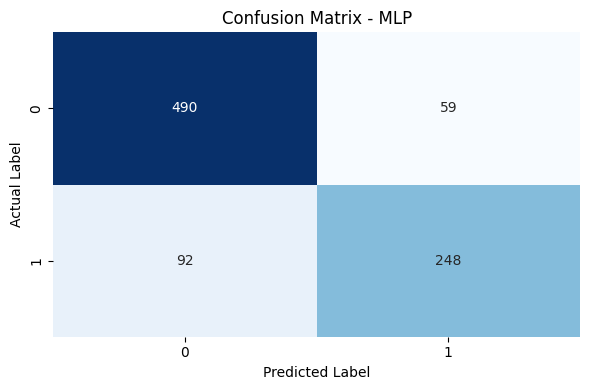

--------------------------------------------------
Evaluating model: RFC
RFC - Accuracy: 0.8178, Precision: 0.7853, Recall: 0.7206


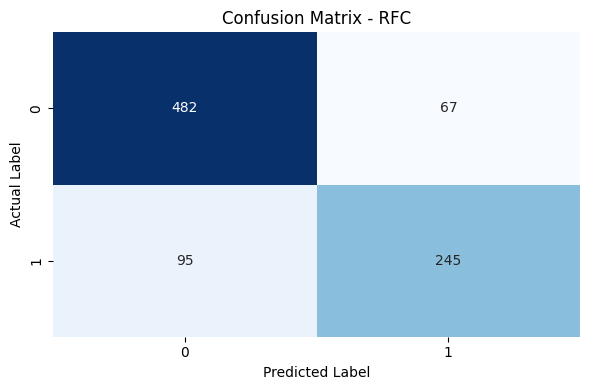

--------------------------------------------------
Evaluating model: SVC
SVC - Accuracy: 0.8245, Precision: 0.7754, Recall: 0.7618


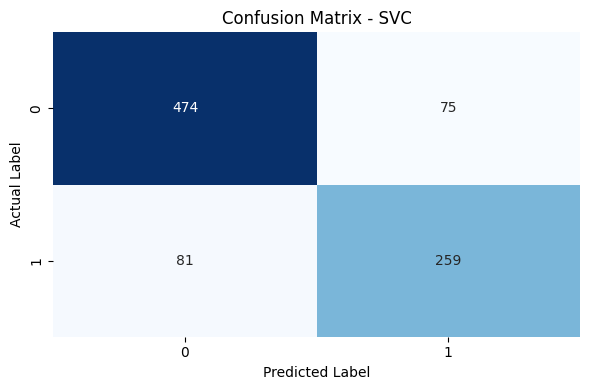

--------------------------------------------------
Evaluating model: AdaB
AdaB - Accuracy: 0.8279, Precision: 0.7825, Recall: 0.7618


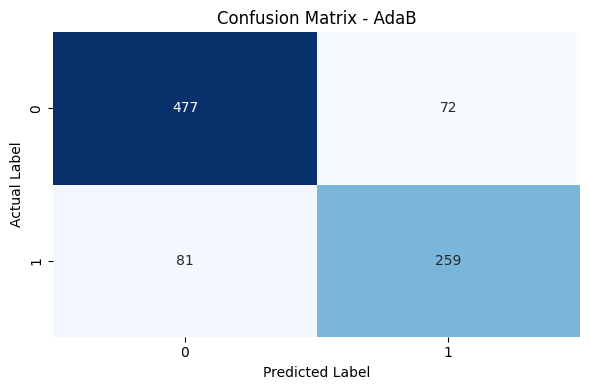

--------------------------------------------------
Evaluating model: GBC
GBC - Accuracy: 0.8358, Precision: 0.8255, Recall: 0.7235


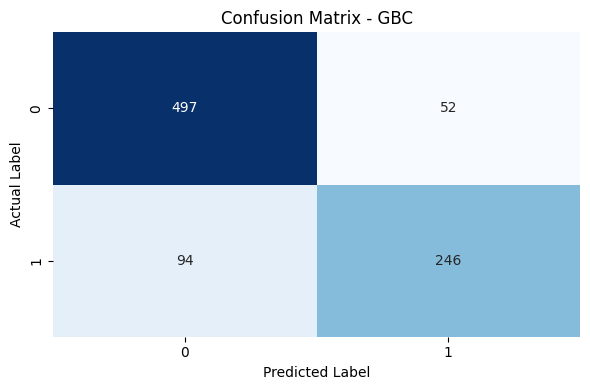

--------------------------------------------------
Evaluating model: DTC
DTC - Accuracy: 0.8065, Precision: 0.7781, Recall: 0.6912


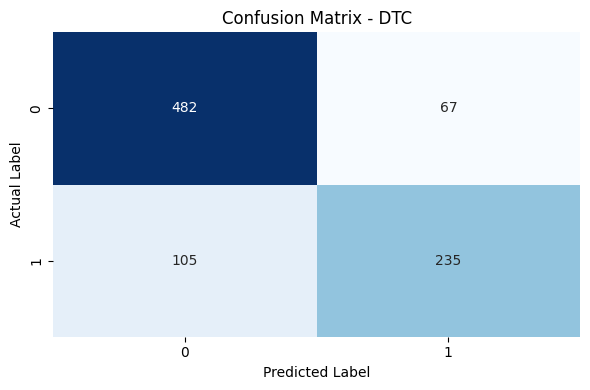

--------------------------------------------------
Evaluating model: XGB
XGB - Accuracy: 0.8279, Precision: 0.8026, Recall: 0.7294


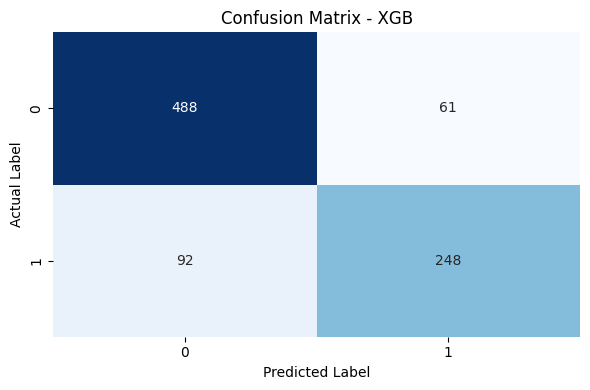

--------------------------------------------------
Evaluating model: LR
LR - Accuracy: 0.8211, Precision: 0.7734, Recall: 0.7529


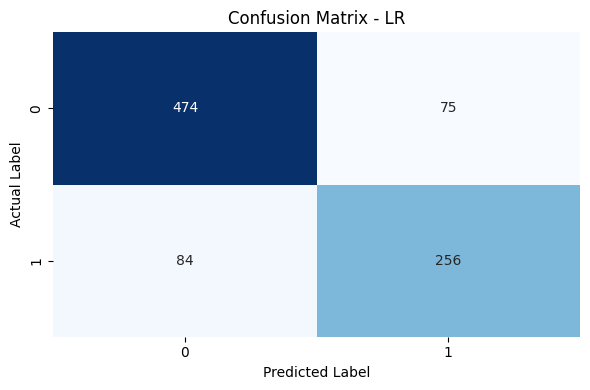

--------------------------------------------------


In [54]:
# Loop through all trained models
for name, model in trained_models.items():
    print(f"Evaluating model: {name}")
    
    # Generate cross-validated predictions
    y_train_pred = cross_val_predict(model, X_train_scaled, y_train_true, cv=cv)
    
    # Compute metrics
    acc = accuracy_score(y_train_true, y_train_pred)
    precision = precision_score(y_train_true, y_train_pred)
    recall = recall_score(y_train_true, y_train_pred)
    
    # Print metrics
    print(f"{name} - Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_train_true, y_train_pred, name)
    print("-"*50)

Evaluating MLP...


c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Projects\github_venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic 

Evaluating RFC...
Evaluating SVC...
Evaluating AdaB...
Evaluating GBC...
Evaluating DTC...
Evaluating XGB...
Evaluating LR...
  Model  Accuracy  Precision    Recall        F1
0   MLP  0.823397   0.798046  0.720588  0.757342
1   RFC  0.816648   0.780952  0.723529  0.751145
2   SVC  0.816648   0.768997  0.744118  0.756353
3  AdaB  0.812148   0.750725  0.761765  0.756204
4   GBC  0.815523   0.789474  0.705882  0.745342
5   DTC  0.799775   0.762987  0.691176  0.725309
6   XGB  0.821147   0.792880  0.720588  0.755008
7    LR  0.811024   0.757485  0.744118  0.750742


C:\Users\Milos\AppData\Local\Temp\ipykernel_20636\310970993.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
C:\Users\Milos\AppData\Local\Temp\ipykernel_20636\310970993.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
C:\Users\Milos\AppData\Local\Temp\ipykernel_20636\310970993.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
C:\Users\Milos\AppData\Local\Temp\ipy

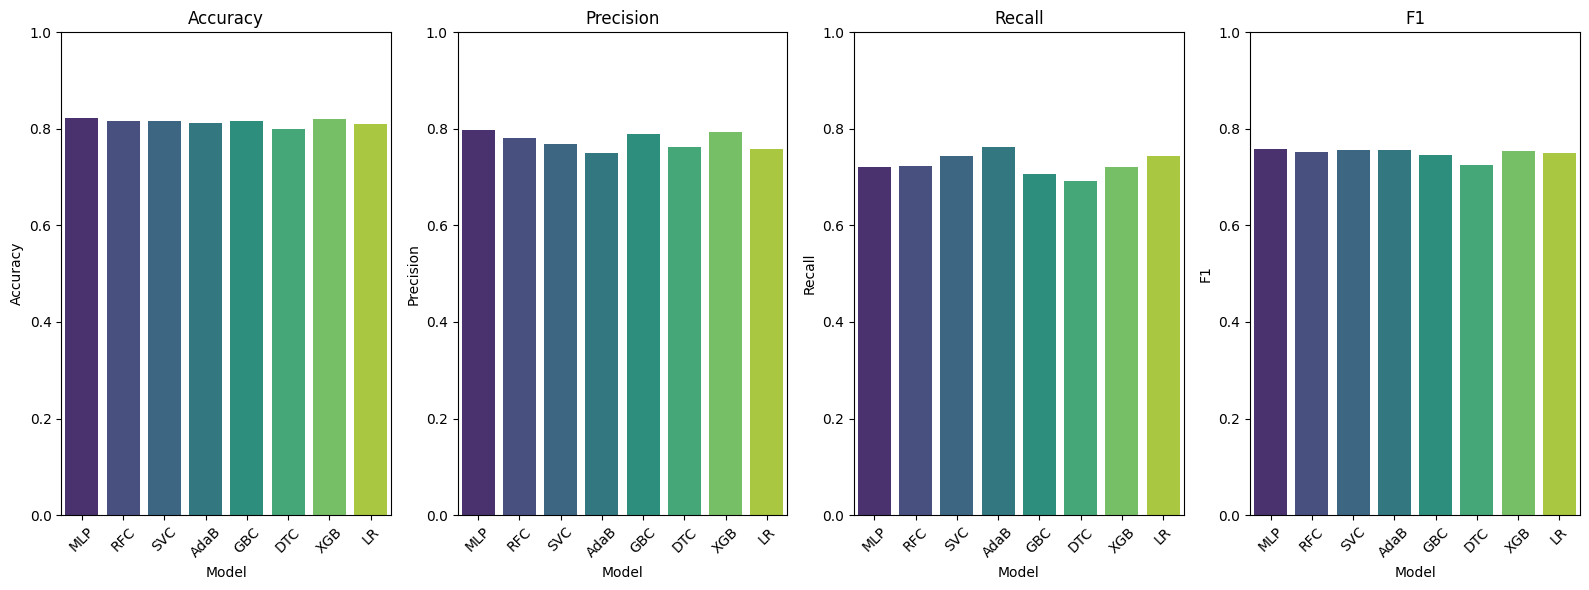

In [55]:
# Dictionary to store results
metrics_summary = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

# Loop through all trained models
for name, model in models:
    print(f"Evaluating {name}...")
    
    # Get cross-validated predictions
    y_pred = cross_val_predict(model, X_train_scaled, y_train_true, cv=5)
    
    # Calculate metrics
    acc = accuracy_score(y_train_true, y_pred)
    prec = precision_score(y_train_true, y_pred)
    rec = recall_score(y_train_true, y_pred)
    f1 = f1_score(y_train_true, y_pred)
    
    # Store results
    metrics_summary['Model'].append(name)
    metrics_summary['Accuracy'].append(acc)
    metrics_summary['Precision'].append(prec)
    metrics_summary['Recall'].append(rec)
    metrics_summary['F1'].append(f1)

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)

# Plot bar charts for each metric
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
plt.figure(figsize=(16, 6))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(1, 4, i)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.title(metric)

plt.tight_layout()
plt.show()

### Feature Importance

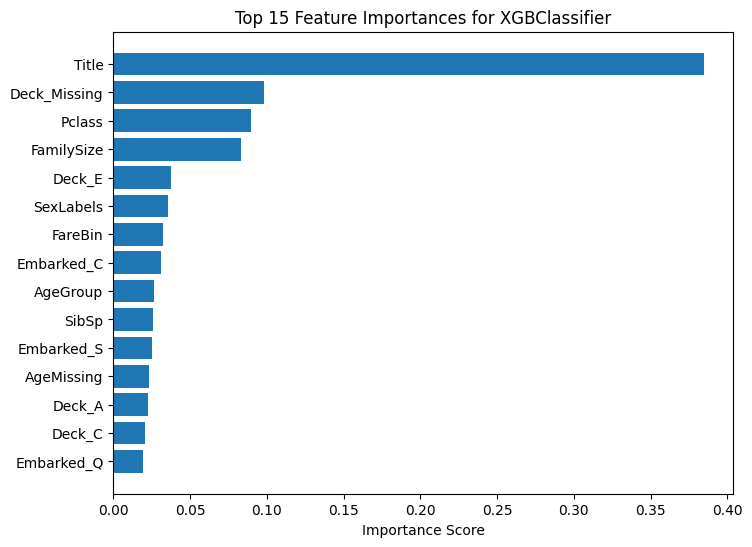

In [56]:
plot_feature_importance(trained_models['XGB'], X_train_scaled.columns)

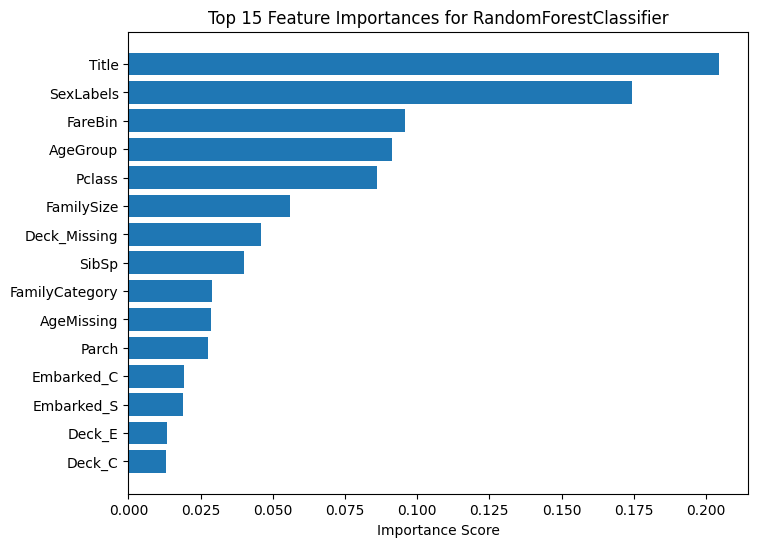

In [57]:
plot_feature_importance(trained_models['RFC'], X_train_scaled.columns)

## 7) Making Predictions on TEST SET - USING THE BEST MODEL

In [58]:
# Make predictions
y_test_pred = trained_models['MLP'].predict(X_test_scaled)

#Probabilities (ROC curves)
y_test_proba = trained_models['MLP'].predict_proba(X_test_scaled)[:, 1]

#Create a DataFrame for submission
submission = pd.DataFrame({
    'PassengerId': datasets['test']['PassengerId'],
    'Survived': y_test_pred
})

# Save to CSV
submission.to_csv('titanic_mlp_predictions.csv', index=False)

## 🏁 Conclusion

- The MLP and XGB model achieved the highest accuracy of 82%.
- Newly engineered feature Title was the most important predictors of survival.
- Future improvements could include hyperparameter tuning and ensemble stacking.